In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import csv
import joblib
import re
import string
import unicodedata
import nltk
#nltk.download("punkt")
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import *
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# code_preparation

In [2]:
df0 = pd.read_csv("C:/Users/Asus/PYTHON_C/DLBDSME01/spam_filter/data/raw/SMSSpamCollection.csv", sep='\t',names=["message"], 
                  encoding='ISO-8859-1',index_col=False)
df0.head()

,message
0,"ham,Go until jurong point, crazy.. Available o..."
1,"ham,Ok lar... Joking wif u oni..."
2,"spam,Free entry in 2 a wkly comp to win FA Cup..."
3,"ham,U dun say so early hor... U c already then..."
4,"ham,Nah I don't think he goes to usf, he lives..."


In [3]:
df0[['label', 'text']] = df0['message'].str.split(',', 1, expand=True)
df0.head()

,message,label,text
0,"ham,Go until jurong point, crazy.. Available o...",ham,"Go until jurong point, crazy.. Available only ..."
1,"ham,Ok lar... Joking wif u oni...",ham,Ok lar... Joking wif u oni...
2,"spam,Free entry in 2 a wkly comp to win FA Cup...",spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,"ham,U dun say so early hor... U c already then...",ham,U dun say so early hor... U c already then say...
4,"ham,Nah I don't think he goes to usf, he lives...",ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
del df0['message']
df0.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df = df0.to_csv("C:/Users/Asus/PYTHON_C/DLBDSME01/spam_filter/data/processed/SMSSpamColl.csv", index=False)

In [6]:
df = pd.read_csv("C:/Users/Asus/PYTHON_C/DLBDSME01/spam_filter/data/processed/SMSSpamColl.csv", encoding='utf-8')
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df = df[['text','label']]
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [8]:
df.shape

(5574, 2)

In [9]:
df['text'].isna().sum()

0

In [10]:
df['label'].isna().sum()

0

In [11]:
#labeling
reviews = np.array(df['text'])[:]
labels = np.array(df['label'])[:]
Counter(labels)

Counter({'ham': 4827, 'spam': 747})

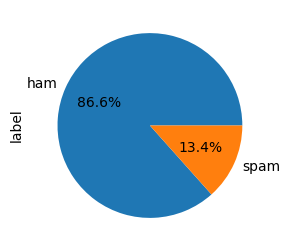

In [12]:
label_count = df['label'].value_counts()
plot_users=label_count.plot.pie(autopct='%1.1f%%', figsize=(3, 3))
plt.rc('axes', unicode_minus=False)
plt.savefig("../spam_filter/docs/images/label_count_chart.jpeg",transparent=False, bbox_inches='tight',pad_inches=0.1)

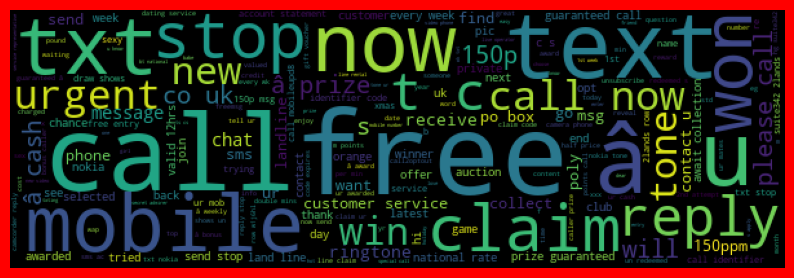

In [13]:
# Plotting the word cloud of spam words

spam_words = ""

# Loop all texts where label is 'spam'
for value in df[df['label'] == 'spam'].text:
    lowercase_text = value.lower()
    tokens = nltk.word_tokenize(lowercase_text)
    for word in tokens:
        spam_words = spam_words + word + ' '

spam_wordcloud = WordCloud(background_color="Black", width=600, height=200).generate(spam_words)

# Plot the word cloud 
plt.figure( figsize=(10,10), facecolor='r')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.savefig('../spam_filter/docs/images/spam_wordcloud.jpeg',
            transparent=False, bbox_inches='tight',pad_inches=0.1)
plt.show()

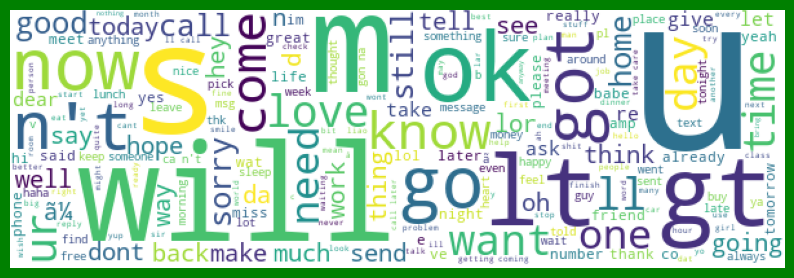

In [14]:
# Plotting the word cloud of NOT spam words

ham_words = ""

# Loop all texts where label is 'ham'
for value in df[df['label'] == 'ham'].text:
    lowercase_text = value.lower()
    tokens = nltk.word_tokenize(lowercase_text)
    for word in tokens:
        ham_words = ham_words + word + ' '

ham_wordcloud = WordCloud(background_color="White", width=600, height=200).generate(ham_words)

# Plot the word cloud 
plt.figure( figsize=(10,10), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.savefig('../spam_filter/docs/images/ham_wordcloud.jpeg',
            transparent=False, bbox_inches='tight',pad_inches=0.1)
plt.show()

# code_model_selection

## Cleaning

In [15]:
def clean_text(text):
    import re
    from string import punctuation
    text=re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', 
                ' ', text)
    text=re.sub(r'['+punctuation+']',' ',text)
    text=re.sub(r'#(\w+)',' ',text)
    text=re.sub(r'@(\w+)',' ',text)
    text = text.lower() # Convert  to lowercase

    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)

    lemmatizer = WordNetLemmatizer()
    stems = [lemmatizer.lemmatize(t) for t in tokens]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in stems]
    
    return ' '.join(stems)

def tokenize(text):
    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)
    
    return tokens    

## Vectorizer tf-idf

In [16]:
cv=TfidfVectorizer(lowercase=True,preprocessor=clean_text,stop_words='english',
                   ngram_range=(1,3),tokenizer=tokenize)

text_counts=cv.fit_transform(df['text'].values.astype('U'))

## Split into training and testing data

In [17]:
x_train,x_test,y_train,y_test =train_test_split(text_counts, df['label'],stratify=df['label'],random_state=42,test_size=0.3)


# Evaluate Models:

Classification report
Model with high accuracy but low precision might be overfitting.

Model with a low accuracy but high precision might be underfitting.

Model with a high f1-score means have a good balance between accuracy and recall, have better overall performance.

The confusion matrix is a table that shows the number of true positive, true negative, false positive, and false negative predictions made by the model. The confusion matrix shows the number of times the model correctly (true positive and true negative) and incorrectly (false positive and false negative) predicted each class.

In [18]:
def performance_evaluation():

#def Classification_report():
    class_report = classification_report(y_test, y_pred)
    print(class_report)
    
#def conf_matrix_img():    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    print("")
    #Normalized Confusion Matrix
    nconf_matrix = np.round(conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis],1)
    print(nconf_matrix)    

#def heatmap_image():    
    le = LabelEncoder()
    le.fit(labels)
    class_labels = le.classes_
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Blues, fmt="d", xticklabels=class_labels, yticklabels=class_labels, ax=ax1)
    ax1.set_xlabel("Predicted labels")
    ax1.set_ylabel("True labels")
    ax1.set_title("Confusion Matrix")
    sns.heatmap(nconf_matrix, annot=True, cmap=plt.cm.Greens, fmt=".2f", xticklabels=class_labels, yticklabels=class_labels, ax=ax2)
    ax2.set_xlabel("Predicted labels")
    ax2.set_ylabel("True labels")
    ax2.set_title("Normalized")
    # Add some space between the subplots
    plt.subplots_adjust(wspace=1)

    # Set the aspect ratio to "equal"
    ax1.set_aspect("equal")
    ax2.set_aspect("equal")

    # Save the chart to a file
    #plt.savefig('../spam_filter/docs/images/combined_heatmaps.jpeg',transparent=False,
    #bbox_inches='tight', pad_inches=0.1)
    plt.show()

## Logistic regression Classifier

In [19]:
# Logistic Regression
clf = LogisticRegression(C=0.2)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.8661087866108786

## Logistic regression + L1 Regulation

In [21]:
# Logistic Regression
clf = LogisticRegression(penalty='l1', solver = 'saga', C=0.2)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)
print("Accuracy with L1 regularization: ", metrics.accuracy_score(y_test, y_pred))

Accuracy with L1 regularization:  0.8918111177525403


## Logistic regression + L1 Regulation + Cross Validation

In [23]:
clf = LogisticRegression(penalty='l1', solver = 'saga', C=0.2)
scores = cross_val_score(clf, x_train, y_train, cv=4)
print("Cross Validation Scores: ", scores)
print("Average Cross Validation Score: ", np.mean(scores))

clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy with L1 regularization and cross validation: ", metrics.accuracy_score(y_test, y_pred))

Cross Validation Scores:  [0.87192623 0.87384615 0.87589744 0.87384615]
Average Cross Validation Score:  0.873878993274485
Accuracy with L1 regularization and cross validation:  0.8798565451285116


## Logistic regression + L2 Regulation + Cross Validation

In [24]:
clf = LogisticRegression(penalty='l2', solver = 'lbfgs', C=0.2)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)
print("Accuracy with L2 regularization: ", metrics.accuracy_score(y_test, y_pred))

Accuracy with L2 regularization:  0.8661087866108786


In [25]:
clf = LogisticRegression(penalty='l2', solver = 'lbfgs', C=0.2)
scores = cross_val_score(clf, x_train, y_train, cv=6)
print("Cross Validation Scores: ", scores)
print("Average Cross Validation Score: ", np.mean(scores))

clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy with L2 regularization and cross validation: ", metrics.accuracy_score(y_test, y_pred))

Cross Validation Scores:  [0.86482335 0.86615385 0.86615385 0.86615385 0.86615385 0.86615385]
Average Cross Validation Score:  0.865932096577258
Accuracy with L2 regularization and cross validation:  0.8661087866108786


In [26]:
#SAVE MODEL

def train_models():
    file = open('../spam_filter/src/code_model_deploy/vectorizer.pkl','wb')
    joblib.dump(cv, file)
    file.close()

    file = open('../spam_filter/src/code_model_deploy/model.pkl','wb')
    joblib.dump(clf, file)
    file.close()
    
    print("Models saved")
    
train_models()

Models saved


In [27]:
#LOAD MODEL

def load_models():  
       
    # Load the vectorizer.
    file = open('../spam_filter/src/code_model_deploy/vectorizer.pkl', 'rb')
    vectorizer = joblib.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('../spam_filter/src/code_model_deploy/model.pkl', 'rb')
    model = joblib.load(file)
    file.close()
    
    return vectorizer, model

vectorizer, model = load_models()

# Make predictions
user_input = input("Enter your message:")
clean_input = clean_text(user_input)
input_counts = vectorizer.transform([clean_input])
prediction = model.predict(input_counts)
print(prediction)

Enter your message:You are awarded with cash $500000
['ham']


              precision    recall  f1-score   support

         ham       0.87      1.00      0.93      1449
        spam       0.00      0.00      0.00       224

    accuracy                           0.87      1673
   macro avg       0.43      0.50      0.46      1673
weighted avg       0.75      0.87      0.80      1673

[[1449    0]
 [ 224    0]]

[[1. 0.]
 [1. 0.]]


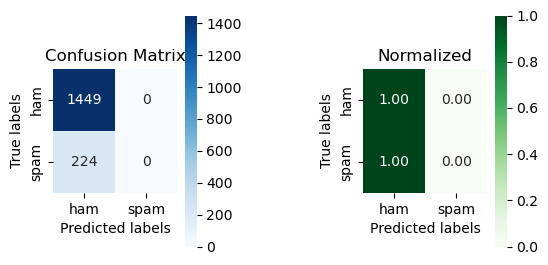

In [28]:
performance_evaluation()

#### The model is very strong in identifying ham,  but very weak in identifying spam.
#### Recall = 0.00 for spam means: only can identify 0% of actual spam.
#### f1-score = 0.00 for spam means: this model's ability to detect spam is only 0%.

## Bernoulli NB Classifier

In [28]:
#Ber_NB
clf=BernoulliNB()
clf.fit(x_train,y_train)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.9252839210998207

## Bernoulli NB + Cross validation

In [33]:
#Ber_NB with cross validation
clf = BernoulliNB()
scores = cross_val_score(clf, x_train, y_train, cv=5)
print("Accuracy with cross validation: ", scores.mean())

Accuracy with cross validation:  0.882851045667947


In [34]:
#SAVE MODEL
train_models()

Models saved


In [35]:
# LOAD MODEL
vectorizer, model = load_models()
model.fit(x_train, y_train)

# Make predictions
user_input = input("Enter your message:")
clean_input = clean_text(user_input)
input_counts = vectorizer.transform([clean_input])
prediction = model.predict(input_counts)
print(prediction)

Enter your message:You won lucky price and got $7000000
['ham']


              precision    recall  f1-score   support

         ham       0.92      1.00      0.96      1464
        spam       0.98      0.41      0.58       209

    accuracy                           0.93      1673
   macro avg       0.95      0.71      0.77      1673
weighted avg       0.93      0.93      0.91      1673

[[1462    2]
 [ 123   86]]

[[1.  0. ]
 [0.6 0.4]]


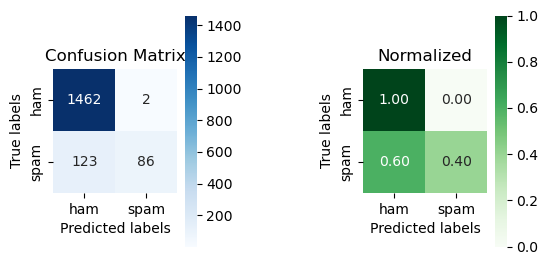

In [36]:
performance_evaluation()

#### Although has high accuracy, the model is struggling when identifying spam.
#### Recall = 0.41 for spam means: only can identify 41% of actual spam.
#### f1-score = 0.58 for spam means: this model's ability to detect spam is 58%.

## Gaussian Naive Bayes Classifier

In [37]:
#Single Naive Bayes
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
x_train_dense = np.array(x_train.toarray())
x_test_dense = np.array(x_test.toarray())
clf.fit(x_train_dense, y_train)
y_pred = clf.predict(x_test_dense)
metrics.accuracy_score(y_test, y_pred)

0.9306634787806336

In [38]:
#SAVE MODEL
train_models()

Models saved


In [39]:
#LOAD MODEL
vectorizer, model = load_models()
user_input = input("Enter your message:")
clean_input = clean_text(user_input)
input_counts = vectorizer.transform([clean_input]).toarray()
prediction = model.predict(input_counts)
print(prediction)

Enter your message:You won lucky prize $400000
['spam']


              precision    recall  f1-score   support

         ham       0.98      0.94      0.96      1464
        spam       0.67      0.89      0.76       209

    accuracy                           0.93      1673
   macro avg       0.82      0.92      0.86      1673
weighted avg       0.94      0.93      0.93      1673

[[1370   94]
 [  22  187]]

[[0.9 0.1]
 [0.1 0.9]]


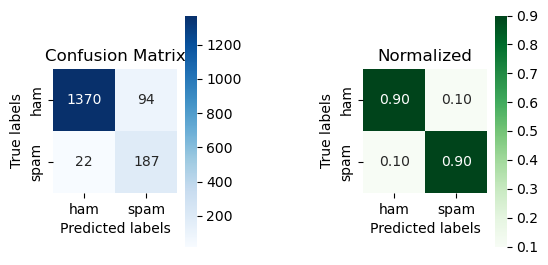

In [40]:
performance_evaluation()

#### precision of 0.67 for spam means: 67% of predicted as spam are actually spam (33% of predicted as spam are actually NOT spam).

## Linear SVC Classifier

In [41]:
#Linear SVC
clf = svm.LinearSVC()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.9754931261207412

## Linear SVC + L1 Regulation + Cross Validation

In [42]:
clf = svm.LinearSVC(penalty='l1', loss='squared_hinge', C=0.3, dual=False)
scores = cross_val_score(clf, x_train, y_train, cv=4)
print("Cross Validation Scores: ", scores)
print("Average Cross Validation Score: ", np.mean(scores))

clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy with L1 regularization and cross validation: ", metrics.accuracy_score(y_test, y_pred))

Cross Validation Scores:  [0.93237705 0.9425641  0.94461538 0.94358974]
Average Cross Validation Score:  0.9407865699873896
Accuracy with L1 regularization and cross validation:  0.949193066347878


## Linear SVC + L2 Regulation + Cross Validation

In [43]:
clf = svm.LinearSVC(penalty='l2', C=0.3, dual=False)
scores = cross_val_score(clf, x_train, y_train, cv=4)
print("Cross Validation Scores: ", scores)
print("Average Cross Validation Score: ", np.mean(scores))

clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy with L2 regularization and cross validation: ", metrics.accuracy_score(y_test, y_pred))

Cross Validation Scores:  [0.94364754 0.95179487 0.94461538 0.94769231]
Average Cross Validation Score:  0.9469375262715426
Accuracy with L2 regularization and cross validation:  0.9647340107591154


In [44]:
#SAVE MODEL
train_models()

Models saved


In [45]:
#LOAD MODEL
vectorizer, model = load_models()

# Make predictions
user_input = input("Enter your message:")
clean_input = clean_text(user_input)
input_counts = vectorizer.transform([clean_input])
prediction = model.predict(input_counts)
print(prediction)

Enter your message:You won lucky prize $500000
['spam']


              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1464
        spam       0.99      0.73      0.84       209

    accuracy                           0.96      1673
   macro avg       0.97      0.86      0.91      1673
weighted avg       0.97      0.96      0.96      1673

[[1462    2]
 [  57  152]]

[[1.  0. ]
 [0.3 0.7]]


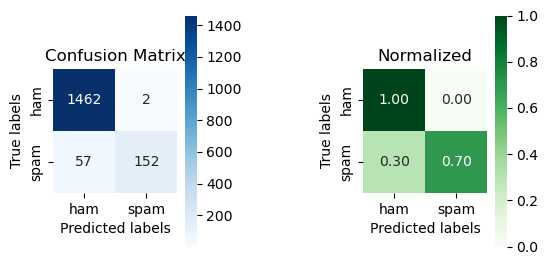

In [46]:
performance_evaluation()

#### Recall = 0.73 for spam means: can identify 73% of actual spam.

## Support Vector Machines Classifier

In [47]:
clf = svm.SVC(kernel='linear')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.9754931261207412

## Support Vector Machines + Cross validation¶

In [48]:
clf = SVC(kernel='linear')
scores = cross_val_score(clf, x_train, y_train, cv=5)
print("Accuracy of SVM with cross validation: ", scores.mean())

Accuracy of SVM with cross validation:  0.9700088643750616


In [49]:
#SAVE MODEL  
train_models()

Models saved


In [52]:
# LOAD MODEL
vectorizer, model = load_models()
model.fit(x_train, y_train)
# Make predictions
user_input = input("Enter your message:")
clean_input = clean_text(user_input)
input_counts = vectorizer.transform([clean_input])
prediction = model.predict(input_counts)
print(prediction)

Enter your message:You won lucky prize $6000000
['spam']


              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1464
        spam       0.98      0.82      0.89       209

    accuracy                           0.98      1673
   macro avg       0.98      0.91      0.94      1673
weighted avg       0.98      0.98      0.97      1673

[[1461    3]
 [  38  171]]

[[1.  0. ]
 [0.2 0.8]]


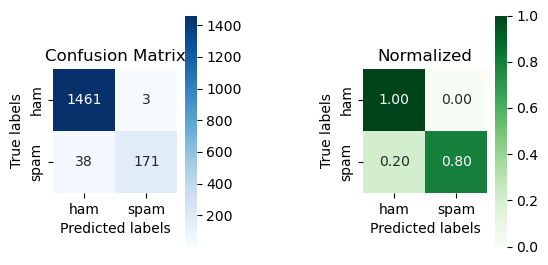

In [53]:
performance_evaluation()

### This model has good performance. The lowest number is 82% for recall for spam

## Decision Tree Classifier

In [54]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.9593544530783025

## Decision Tree Classifier + Cross validation

In [66]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, x_train, y_train, cv = 10)
print("Accuracy of Decision Tree with Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy of Decision Tree with Cross Validation: 0.97 (+/- 0.03)


In [67]:
#SAVE MODEL  
train_models()

Models saved


In [75]:
# LOAD MODEL
vectorizer, model = load_models()
model.fit(x_train, y_train)
# Make predictions
user_input = input("Enter your message:")
clean_input = clean_text(user_input)
input_counts = vectorizer.transform([clean_input])
prediction = model.predict(input_counts)
print(prediction)

Enter your message:You awarded cash $800000
['spam']


              precision    recall  f1-score   support

         ham       0.98      0.97      0.98      1464
        spam       0.83      0.85      0.84       209

    accuracy                           0.96      1673
   macro avg       0.90      0.91      0.91      1673
weighted avg       0.96      0.96      0.96      1673

[[1427   37]
 [  31  178]]

[[1.  0. ]
 [0.1 0.9]]


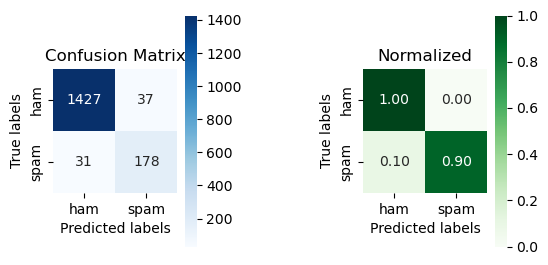

In [76]:
performance_evaluation()

### This model has good performance. The lowest number is 83% precision for spam

In [ ]:
#XGBoost Classifier
#import xgboost as xgb
#from sklearn.preprocessing import LabelEncoder

#Encode the labels as integers
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.transform(y_test)

#Fit the XGBoost classifier
#clf = xgb.XGBClassifier()
#clf.fit(x_train, y_train)
#y_pred = clf.predict(x_test)
#metrics.accuracy_score(y_test, y_pred)

## Multinomial Naive Bayes Classifier

In [29]:
#Multinomial Naive Bayes 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=0.2)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.9886431560071728

## Multinomial Naive Bayes + Cross validation

In [30]:
clf = MultinomialNB(alpha=0.3)
scores = cross_val_score(clf, x_train, y_train, cv=7)
print("Accuracy of Multinomial Naive Bayes with cross validation: ", scores.mean())

Accuracy of Multinomial Naive Bayes with cross validation:  0.9805193133796829


## Save the chosen model and Vectorizer 

In [31]:
#SAVE MODEL
train_models()

Models saved


## Load model and Vectorizer

In [32]:
# LOAD MODEL
vectorizer, model = load_models()
model.fit(x_train, y_train)
# Make predictions
user_input = input("Enter your message:")
clean_input = clean_text(user_input)
input_counts = vectorizer.transform([clean_input])
prediction = model.predict(input_counts)
print(prediction)

Enter your message:You won prize $40000
['spam']


              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1449
        spam       0.98      0.94      0.96       224

    accuracy                           0.99      1673
   macro avg       0.98      0.97      0.98      1673
weighted avg       0.99      0.99      0.99      1673

[[1444    5]
 [  14  210]]

[[1.  0. ]
 [0.1 0.9]]


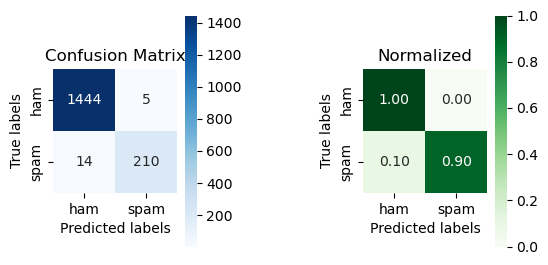

In [33]:
performance_evaluation()

### This is the best model so far with highest precision, recall, f1-score, accuracy for both ham and spam.
### The lowest number is 94% recall for spam 

# Deploy locally

In [82]:
%%writefile spam_filter.py


import numpy as np
import pandas as pd
import csv
import joblib
import streamlit as st
import unicodedata
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import *
from sklearn.preprocessing import LabelEncoder

def clean_text(text):
    import re
    from string import punctuation
    text=re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', 
                ' ', text)
    text=re.sub(r'['+punctuation+']',' ',text)
    text=re.sub(r'#(\w+)',' ',text)
    text=re.sub(r'@(\w+)',' ',text)
    text = text.lower() # Convert  to lowercase

    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)

    lemmatizer = WordNetLemmatizer()
    stems = [lemmatizer.lemmatize(t) for t in tokens]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in stems]
    
    return ' '.join(stems)

def tokenize(text):
    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)
    
    return tokens    

def load_models():     
    # Load the vectorizer.
    file = open('../spam_filter/src/code_model_deploy/vectorizer.pkl', 'rb')
    vectorizer = joblib.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('../spam_filter/src/code_model_deploy/model.pkl', 'rb')
    model = joblib.load(file)
    file.close()
    
    return vectorizer, model

df = pd.read_csv('../spam_filter/data/processed/SMSSpamColl.csv', encoding='utf-8')
cv=TfidfVectorizer(lowercase=True,preprocessor=clean_text,stop_words='english',ngram_range=(1,3),tokenizer=tokenize)
text_counts=cv.fit_transform(df['text'].values.astype('U'))
x_train, x_test, y_train, y_test = train_test_split(text_counts,df['label'],test_size=0.3)

def main():    
    st.title("Spam Classifier")
    st.write("Enter your message to check if it's spam or not.")
    user_input = st.text_input("Enter message here:")
    
    if st.button("Check"):                  
    # Make predictions
        vectorizer, model = load_models()
        model.fit(x_train, y_train) 
        clean_input = clean_text(user_input)
        input_counts = vectorizer.transform([clean_input])
        prediction = model.predict(input_counts)[0]
        st.write("Prediction: ", prediction)

if __name__ == '__main__':
    main()


Overwriting spam_filter.py


# Deploy to the cloud

In [83]:
%%writefile spam_classifier.py

import numpy as np
import pandas as pd
import csv
import joblib
import streamlit as st
import unicodedata
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import *
from sklearn.preprocessing import LabelEncoder

def clean_text(text):
    import re
    from string import punctuation
    text=re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', 
                ' ', text)
    text=re.sub(r'['+punctuation+']',' ',text)
    text=re.sub(r'#(\w+)',' ',text)
    text=re.sub(r'@(\w+)',' ',text)
    text = text.lower() # Convert  to lowercase

    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)

    lemmatizer = WordNetLemmatizer()
    stems = [lemmatizer.lemmatize(t) for t in tokens]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in stems]
    
    return ' '.join(stems)

def tokenize(text):
    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)
    
    return tokens    

def load_models():     
    # Load the vectorizer.
    file = open('vectorizer.pkl', 'rb')
    vectorizer = joblib.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('model.pkl', 'rb')
    model = joblib.load(file)
    file.close()
    
    return vectorizer, model

df = pd.read_csv('SMSSpamColl.csv', encoding='utf-8')
cv=TfidfVectorizer(lowercase=True,preprocessor=clean_text,stop_words='english',ngram_range=(1,3),tokenizer=tokenize)
text_counts=cv.fit_transform(df['text'].values.astype('U'))
x_train, x_test, y_train, y_test = train_test_split(text_counts,df['label'],test_size=0.3)

def main():    
    st.title("Spam Classifier")
    st.write("Enter your message to check if it's spam or not.")
    user_input = st.text_input("Enter message here:")
    
    if st.button("Check"):                  
    # Make predictions
        vectorizer, model = load_models()
        model.fit(x_train, y_train) 
        clean_input = clean_text(user_input)
        input_counts = vectorizer.transform([clean_input])
        prediction = model.predict(input_counts)[0]
        st.write("Prediction: ", prediction)

if __name__ == '__main__':
    main()

Overwriting spam_classifier.py


# Deploy locally, append user input as new row in dataset

In [84]:
%%writefile spam_filter_.py

import numpy as np
import pandas as pd
import csv
import joblib
import streamlit as st
import unicodedata
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import *
from sklearn.preprocessing import LabelEncoder

def clean_text(text):
    import re
    from string import punctuation
    text=re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', 
                ' ', text)
    text=re.sub(r'['+punctuation+']',' ',text)
    text=re.sub(r'#(\w+)',' ',text)
    text=re.sub(r'@(\w+)',' ',text)
    text = text.lower() # Convert  to lowercase

    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)

    lemmatizer = WordNetLemmatizer()
    stems = [lemmatizer.lemmatize(t) for t in tokens]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in stems]
    
    return ' '.join(stems)

def tokenize(text):
    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)
    
    return tokens    

def load_models():     
    # Load the vectorizer.
    file = open('../spam_filter/src/code_model_deploy/vectorizer.pkl', 'rb')
    vectorizer = joblib.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('../spam_filter/src/code_model_deploy/model.pkl', 'rb')
    model = joblib.load(file)
    file.close()
    
    return vectorizer, model

df = pd.read_csv('../spam_filter/data/processed/SMSSpamColl.csv', encoding='utf-8')
cv=TfidfVectorizer(lowercase=True,preprocessor=clean_text,stop_words='english',ngram_range=(1,3),tokenizer=tokenize)
text_counts=cv.fit_transform(df['text'].values.astype('U'))
x_train, x_test, y_train, y_test = train_test_split(text_counts,df['label'],test_size=0.3)

def predict(user_input, vectorizer, model):
    # Make predictions
    clean_input = clean_text(user_input)
    input_counts = vectorizer.transform([clean_input])
    prediction = model.predict(input_counts)[0]
    return prediction

def main():
    st.title("Spam Classifier")
    st.write("Enter your message to check if it's spam or not.")
    user_input = st.text_input("Enter message here:")
    if st.button("Check"):
        # Load models
        vectorizer, model = load_models()
        model.fit(x_train, y_train)
        
        # Make prediction
        prediction = predict(user_input, vectorizer, model)
        st.write("Prediction: ", prediction)
        
        # Add prediction to dataframe and save to file
        df = pd.read_csv('SMSSpamColl.csv', sep='\t', names=['label', 'text'], encoding='utf-8')
        new_row = pd.DataFrame({'label': [prediction], 'text': [user_input]})
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('../spam_filter/data/processed/SMSSpamColl.csv',index=False, sep='\t', mode='a')
        st.write("New row added to file.")
        
if __name__ == '__main__':
    main()

Overwriting spam_filter_.py
